In [8]:
import montlake
2+2

4

In [9]:
help(montlake)

Help on package montlake:

NAME
    montlake

PACKAGE CONTENTS
    None
    _nbdev
    atomgeom (package)
    core
    exec (package)
    geometry (package)
    gradients (package)
    mflasso (package)
    optimization (package)
    plotting (package)
    simulations (package)
    statistics (package)
    tslasso (package)
    utils (package)
    vendor (package)

VERSION
    0.0.1

FILE
    /Users/samsonkoelle/miniconda3/envs/montlake_xxx/lib/python3.6/site-packages/montlake/__init__.py




In [10]:
# AUTOGENERATED! DO NOT EDIT! File to edit: nbs/optimization.gradientgrouplasso.ipynb (unless otherwise specified).

__all__ = ['GradientGroupLasso', 'get_sr_lambda_parallel', 'batch_stream']

# Cell
#loosely inspired by the pyglmnet package
from einops import rearrange
#import autograd.numpy as np
import numpy as np

class GradientGroupLasso:

    def __init__(self, dg_M, df_M, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None):

        n = dg_M.shape[0]
        d= dg_M.shape[1]
        m = df_M.shape[2]
        p = dg_M.shape[2]
        dummy_beta = np.ones((n,p,m))

        self.dg_M = dg_M
        self.df_M = df_M
        self.reg_l1s = reg_l1s
        self.reg_l2 = reg_l2
        self.beta0_npm = beta0_npm
        self.n = n
        self.p = p
        self.m = m
        self.d = d
        self.dummy_beta = dummy_beta
        #self.group = np.asarray(group)
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tol = tol
        self.Tau = None
        self.alpha = 1.
        self.lossresults = {}
        self.dls = {}
        self.l2loss = {}
        self.penalty = {}

    def _prox(self,beta_npm, thresh):
        """Proximal operator."""

        p = self.p
        result = np.zeros(beta_npm.shape)
        result = np.asarray(result, dtype = float)
        for j in range(p):
            if np.linalg.norm(beta_npm[:,j,:]) > 0.:
                potentialoutput = beta_npm[:,j,:] - (thresh / np.linalg.norm(beta_npm[:,j,:])) * beta_npm[:,j,:]
                posind = np.asarray(np.where(beta_npm[:,j,:] > 0.))
                negind = np.asarray(np.where(beta_npm[:,j,:] < 0.))
                po = beta_npm[:,j,:].copy()
                po[posind[0],posind[1]] = np.asarray(np.clip(potentialoutput[posind[0],posind[1]],a_min = 0., a_max = 1e15), dtype = float)
                po[negind[0],negind[1]] = np.asarray(np.clip(potentialoutput[negind[0],negind[1]],a_min = -1e15, a_max = 0.), dtype = float)
                result[:,j,:] = po
        return result

    def _grad_L2loss(self, beta_npm):

        df_M = self.df_M
        dg_M = self.dg_M
        reg_l2 = self.reg_l2
        dummy_beta = self.dummy_beta

        df_M_hat = np.einsum('ndp,npm->ndm',dg_M, beta_npm)
        error = df_M_hat - df_M
        grad_beta = np.einsum('ndm,ndp->npm',error,dg_M) #+ reg_l2 * np.ones()
        #if
        return grad_beta

    def _L1penalty(self, beta_npm):

        p = self.p
        m = self.m
        n = self.n
        beta_mn_p = rearrange(beta_npm, 'n p m -> (m n) p')#np.reshape(beta_mnp, ((m*n,p)))
        L1penalty = np.linalg.norm(beta_mn_p, axis = 0).sum()

        return L1penalty

    def _loss(self,beta_npm, reg_lambda):
        """Define the objective function for elastic net."""
        L = self._logL(beta_npm)
        P = self._L1penalty(beta_npm)
        J = -L + reg_lambda * P
        return J

    def _logL(self,beta_npm):

        df_M = self.df_M
        dg_M = self.dg_M

        df_M_hat = np.einsum('ndp,npm -> ndm',dg_M, beta_npm)
        logL = -0.5 * np.linalg.norm((df_M - df_M_hat))**2
        return(logL)

    def _L2loss(self,beta_npm):
        output = -self._logL(beta_npm)
        return(output)

    def fhatlambda(self,learning_rate,beta_npm_new,beta_npm_old):

        #print('lr',learning_rate)
        output = self._L2loss(beta_npm_old) + np.einsum('npm,npm', self._grad_L2loss(beta_npm_old),(beta_npm_new-beta_npm_old)) + (1/(2*learning_rate)) * np.linalg.norm(beta_npm_new-beta_npm_old)**2

        return(output)

    def _btalgorithm(self,beta_npm ,learning_rate,b,maxiter_bt,rl):

        grad_beta = self._grad_L2loss(beta_npm = beta_npm)
        for i in range(maxiter_bt):
            beta_npm_postgrad = beta_npm - learning_rate * grad_beta
            beta_npm_postgrad_postprox = self._prox(beta_npm_postgrad, learning_rate * rl)
            fz = self._L2loss(beta_npm_postgrad_postprox)
            #fhatz = self.fhatlambda(lam,beta_npm_postgrad_postprox, beta_npm_postgrad)
            fhatz = self.fhatlambda(learning_rate,beta_npm_postgrad_postprox, beta_npm)
            if fz <= fhatz:
                #print(i)
                break
            learning_rate = b*learning_rate

        return(beta_npm_postgrad_postprox,learning_rate)

    def fit(self, beta0_npm = None):

        reg_l1s = self.reg_l1s
        n = self.n
        m = self.m
        p = self.p

        dg_M = self.dg_M
        df_M = self.df_M

        tol = self.tol
        np.random.RandomState(0)

        if beta0_npm is None:
            beta_npm_hat = 1 / (n*m*p) * np.random.normal(0.0, 1.0, [n, p,m])
            #1 / (n_features) * np.random.normal(0.0, 1.0, [n_features, n_classes])
        else:
            beta_npm_hat = beta0_npm

        fit_params = list()
        for l, rl in enumerate(reg_l1s):
            fit_params.append({'beta': beta_npm_hat})
            if l == 0:
                fit_params[-1]['beta'] = beta_npm_hat
            else:
                fit_params[-1]['beta'] = fit_params[-2]['beta']

            alpha = 1.
            beta_npm_hat = fit_params[-1]['beta']
            #g = np.zeros([n_features, n_classes])
            L, DL ,L2,PEN = list(), list() , list(), list()
            learning_rate = self.learning_rate
            beta_npm_hat_1 = beta_npm_hat.copy()
            beta_npm_hat_2 = beta_npm_hat.copy()
            for t in range(0, self.max_iter):
                #print(t,l,rl)
                #print(t)
                L.append(self._loss(beta_npm_hat, rl))
                L2.append(self._L2loss(beta_npm_hat))
                PEN.append(self._L1penalty(beta_npm_hat))
                w = (t / (t+ 3))
                beta_npm_hat_momentumguess = beta_npm_hat + w*(beta_npm_hat_1 - beta_npm_hat_2)

                beta_npm_hat , learning_rate = self._btalgorithm(beta_npm_hat_momentumguess,learning_rate,.5,1000, rl)
                #print(beta_npm_hat_momentumguess.max(), beta_npm_hat.max(),self._L2loss(beta_npm_hat), learning_rate)
                beta_npm_hat_2 = beta_npm_hat_1.copy()
                beta_npm_hat_1 = beta_npm_hat.copy()

                if t > 1:
                    DL.append(L[-1] - L[-2])
                    if np.abs(DL[-1] / L[-1]) < tol:
                        print('converged', rl)
                        msg = ('\tConverged. Loss function:'
                               ' {0:.2f}').format(L[-1])
                        msg = ('\tdL/L: {0:.6f}\n'.format(DL[-1] / L[-1]))
                        break

            fit_params[-1]['beta'] = beta_npm_hat
            self.lossresults[rl] = L
            self.l2loss[rl] = L2
            self.penalty[rl] = PEN
            self.dls[rl] = DL

        self.fit_ = fit_params
        #self.ynull_ = np.mean(y)

        return self

from einops import rearrange
import numpy as np

In [11]:
import numpy as np
help(np.random.multivariate_normal)

Help on built-in function multivariate_normal:

multivariate_normal(...) method of numpy.random.mtrand.RandomState instance
    multivariate_normal(mean, cov, size=None, check_valid='warn', tol=1e-8)
    
    Draw random samples from a multivariate normal distribution.
    
    The multivariate normal, multinormal or Gaussian distribution is a
    generalization of the one-dimensional normal distribution to higher
    dimensions.  Such a distribution is specified by its mean and
    covariance matrix.  These parameters are analogous to the mean
    (average or "center") and variance (standard deviation, or "width,"
    squared) of the one-dimensional normal distribution.
    
    .. note::
        New code should use the ``multivariate_normal`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    mean : 1-D array_like, of length N
        Mean of the N-dimensional distribution.
    cov : 2-D array_like,

In [13]:
n = 1
d = 2
p = 3

# # sample_grads = .1* np.random.multivariate_normal(np.zeros(d), np.identity(d),p)


# dg_M = np.zeros((n,d ,p))
# dg_M[0] = rearrange(sample_grads, 'p d -> d p')
df_M = np.zeros((n,d ,d))
df_M[0] = np.identity(d)
# df_M[0] = [[np.sqrt(2) / 2, np.sqrt(2) / 2],[np.sqrt(2) / 2, -np.sqrt(2) / 2]]

In [14]:
df_M

array([[[1., 0.],
        [0., 1.]]])

In [33]:
dg_M = np.zeros((n,d,p))
# dg_M[0,:,0] = [.5,0]
# dg_M[0,:,1] = [0,.5]
# delta = .5
# mag = .5 + delta
dg_M[0,:,0] = [1.,0]
dg_M[0,:,1] = [0,1.]
delta = .5
mag = 1. + delta
angle = np.pi / 4
# angle = np.pi / 12
dg_M[0,:,2] = [np.sin(angle) * mag,np.cos(angle) * mag]

In [34]:
gl_itermax = 100000
tol = 1e-16
learning_rate = 10000
GGL = GradientGroupLasso(dg_M, df_M, np.asarray([.00001]), 0., gl_itermax,learning_rate, tol, beta0_npm= None)
GGL.fit()

In [35]:
GGL.fit_[0]['beta'] # we can't just put all the weight on the big one?

array([[[ 0.77445424, -0.22639536],
        [-0.22553337,  0.77359224],
        [ 0.21263758,  0.21345027]]])

In [36]:
np.linalg.norm(df_M[0] - np.einsum('i p d, i e p -> i d e',GGL.fit_[0]['beta'], dg_M))

1.4095500082301197e-05

In [37]:
np.sum(np.abs(GGL.fit_[0]['beta']))

2.4260630631947175

In [38]:
GGL._L1penalty(GGL.fit_[0]['beta'])

1.913954977788813

In [16]:
# n = 1
# d = 4
# p = 30
# sample_grads = .1* np.random.multivariate_normal(np.zeros(d), np.identity(d),p)

# dg_M = np.zeros((n,d ,p))
# dg_M[0] = rearrange(sample_grads, 'p d -> d p')
# df_M = np.zeros((n,d ,d))
# df_M[0] = np.identity(d)

# df_M = np.zeros((n,d ,d))
# df_M[0] = np.identity(2)
# df_M[1] = np.identity(2)

In [193]:
gl_itermax = 100000
tol = 1e-16
learning_rate = 10000

In [194]:
GGL = GradientGroupLasso(dg_M, df_M, np.asarray([.00001]), 0., gl_itermax,learning_rate, tol, beta0_npm= None)
GGL.fit()

In [195]:
np.linalg.norm(dg_M , axis = 1)

array([[0.0746825 , 0.13848074, 0.15381845, 0.09953057, 0.16461224,
        0.13645059, 0.11598697, 0.13391328, 0.09978519, 0.12043461,
        0.14850199, 0.26623018, 0.0785493 , 0.27583127, 0.23963432,
        0.17556931, 0.11773368, 0.08180694, 0.06680022, 0.18362351,
        0.17059862, 0.30011823, 0.19452131, 0.19509776, 0.28501958,
        0.19935068, 0.14379883, 0.1708637 , 0.25582961, 0.12222831]])

In [196]:
# shouldnt we just keep the longest most orthogonal pair?  No.
# it looks like maybe it works...
# before we could see that the dual problem minimizer was actually not the cardinality 2 solution.

In [197]:
GGL._L1penalty(GGL.fit_[0]['beta'])

18.688898035659722

In [199]:
GGL.fit_[0]['beta'] # we can't just put all the weight on the big one?

array([[[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 1.57705054,  0.26917904,  2.90343879,  1.410141  ],
        [-0.38813069, -1.69551913, -2.23436179, -0.95847098],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.90272435,  0.26605372,  0.03071345, -2.17253303],
        [ 2.26462341,  1.33263799, -2.94302153, -1.90316585],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        

In [ ]:
# generally speaking we need to retain at least d dictionary functions

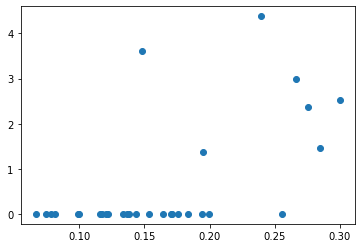

In [200]:
import matplotlib.pyplot as plt

plt.scatter(np.linalg.norm(dg_M , axis = 1), np.linalg.norm(GGL.fit_[0]['beta'], axis = 2))

In [82]:
np.linalg.norm(GGL.fit_[0]['beta'], axis = 2) # the norm on each of the vectors is invariant to the target basis

array([[0.80362935, 0.78955648, 0.32090474]])

In [ ]:
# same amount of norm for each of them?  so it doesn't make sense to say mag**(-1) or things like that...
# but why would we ever prefer the non big aligned vector for that reconstruction??????
# I can add on the other vectors sublinearly due to the 2 norm structure.
# the minimum norm inverse is a type of matrix norm?  is it the inverse of a norm?

In [69]:
mag**(-1) + 0.70710678 + 0.70710678 # this is the naive solution

2.080880226666667

In [ ]:
# anyway so cause of the symmetry we can think of there as being one coefficient per dictionary function
# how many are retained?
# so we've considered the intuition where the long one is the aligned one
# how about the intuition where the other two are aligned.  why does adding the long one make the penalty smaller
# is that case, we can more efficiently use the big one and subtract some of the small ones without accruing much penalty


# maybe we are bounded by d^2 functions retained cause n = d but we have d tasks

In [ ]:
# what is the worst case scenario arrangement of vectors for matching the bp and lasso losses?
# does ambient space regression improve the situation?

# the main thing id like to say is that lambda close to 0 creates a ton of sparsity (e.g. d^2)
# and that the minimizer within that set is close to outside of that set
# if i can establish a worst case scenario, then i can analyze how close the minimizer is within the set to outside of it

In [68]:
np.linalg.lstsq(dg_M[0][:,:2], df_M[0,:,1])

/Users/samsonkoelle/miniconda3/envs/montlake_xxx/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


(array([ 0.70710678, -0.70710678]),
 array([], dtype=float64),
 2,
 array([1., 1.]))

In [62]:
dg_M[0]

array([[1.        , 0.        , 1.06066017],
       [0.        , 1.        , 1.06066017]])

In [36]:
np.linalg.norm(dg_M, axis = 1)

array([[1.  , 1.  , 1.05]])

In [109]:
np.einsum('i p d, i e p -> i d e',GGL.fit_[0]['beta'], dg_M)

array([[[9.99990074e-01, 3.67556745e-07],
        [3.24734653e-07, 9.99990022e-01]]])

In [208]:
# We always take the longest magnitude vector?  appears angle does not matter for this
# rotate target to align with longest vector... then its smaller.  so how is the other smaller?
# its orthogonal to the big one and so has to get pushed sideways by the combination of the other two
# the loss to go sideways is the same as to go straight?  i.e. 2?

In [70]:
from itertools import combinations
subsets =  list(combinations(list(range(p)), d))
asdf = []
for subset in subsets:
    asdf.append(GGL._L1penalty(np.linalg.inv(dg_M[:,:,subset])))

In [71]:
dg_M.shape

(1, 2, 3)

In [72]:
??GGL._L1penalty

In [73]:
def argmin_indices(lst):
    min_value = min(lst)  # Find the minimum value in the list
    return [i for i, x in enumerate(lst) if x == min_value]  # List indices where the element is the minimum value



In [74]:
subsets[argmin_indices(asdf)[0]], min(asdf)

((0, 1), 4.0)

In [81]:
# beta0_npm = GGL.fit_[-1]['beta']
# coeffs[probe_init_low] = GGL.fit_[-1]['beta']
# combined_norms[probe_init_low] = np.sqrt((np.linalg.norm(coeffs[probe_init_low], axis = 0)**2).sum(axis = 1))


You can express any $x_j = \gamma^T x_{[d]}$ where $x_{[d]} \in R^{d \times d}$.

Can we express certain $x_j$ more cheaply i.e. with $\|\gamma\|_2 < 1$? No, not always (think about |<).

But even in that case the ultimate selection is d-sparse.



In [76]:
from montlake.statistics.basispursuit import get_basispursuit_losses
resulttts = get_basispursuit_losses(dg_M,df_M)

In [80]:
resulttts

array([[0.        , 4.        , 4.45780722],
       [0.        , 0.        , 4.45780722],
       [0.        , 0.        , 0.        ]])

In [78]:
??get_basispursuit_losses

In [79]:
dg_M.shape

(1, 2, 3)

In [ ]:
# i should search though all dimensionalities for the basis pursuit losses....
# but it is harder since when p > d they are not well defined
# i can run lasso on subsets and compared penalties.  the optimum solution should have the lowest one.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso

# Generate synthetic data for p > n situation
np.random.seed(42)
n, p = 3, 10  # n observations, p predictors

X = np.random.randn(n, p)
true_beta = np.zeros(p)
true_beta[:10] = np.random.randn(10)  # Only first 10 predictors have non-zero coefficients
y = X @ true_beta + np.random.randn(n) * 0.1  # Add a bit of noise



In [4]:
# Fit Lasso model with a very low lambda (alpha)
lasso = Lasso(alpha=4e-6, tol = 1e-16, max_iter = 100000)
??lasso.fit

In [337]:

lasso.fit(X, y)

# Get the coefficients and count the number of non-zero coefficients
lasso_coef = lasso.coef_
non_zero_coef_count = np.sum(lasso_coef != 0)

# Prepare the results
results = pd.DataFrame({
    'Predictor': np.arange(p),
    'Coefficient': lasso_coef
})

print(f'Number of non-zero coefficients: {non_zero_coef_count}')
print(results)


Number of non-zero coefficients: 4
   Predictor  Coefficient
0          0    -0.540646
1          1    -0.000000
2          2    -0.000000
3          3    -0.774762
4          4    -0.000000
5          5    -0.000000
6          6    -0.016620
7          7    -0.000000
8          8    -0.000000
9          9    -0.024962


/Users/samsonkoelle/miniconda3/envs/montlake_xxx/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2398393206546015e-06, tolerance: 5.381200667582692e-16
  positive)


In [338]:
np.linalg.norm(lasso.predict(X) - y)

9.368458611478848e-06

In [339]:
np.sum(np.abs(lasso.coef_))

1.3569899433347112

In [308]:
X_arr = rearrange(X,'n p -> 1 n p')

In [309]:
y_arr = rearrange(y, 'n -> 1 n 1')

In [310]:
GGL = GradientGroupLasso(X_arr, y_arr, np.asarray([1e-5]), 0., gl_itermax,learning_rate, tol, beta0_npm= None)
GGL.fit()

converged 1e-05


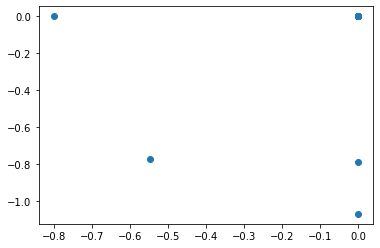

In [311]:
plt.scatter(lasso_coef,GGL.fit_[0]['beta'][0][:,0])

In [340]:
np.linalg.norm(y_arr[0][:,0] - np.einsum('i p j, i n p -> n',GGL.fit_[0]['beta'], X_arr))

1.123108491832222e-05

In [341]:
np.sum(np.abs(GGL.fit_[0]['beta'])) # penalty is much more minimized

2.6313208823088736

In [367]:
import numpy as np
from einops import rearrange

class CoordinateDescentGroupLasso:
    def __init__(self, dg_M, df_M, reg_l1s, reg_l2, max_iter, tol, beta0_npm=None):
        self.dg_M = dg_M
        self.df_M = df_M
        self.reg_l1s = reg_l1s
        self.reg_l2 = reg_l2
        self.beta0_npm = beta0_npm
        self.n, self.d, self.p = dg_M.shape
        self.m = df_M.shape[2]
        self.max_iter = max_iter
        self.tol = tol
        self.lossresults = {}
        self.l2loss = {}
        self.penalty = {}

    def _soft_threshold(self, rho, lam):
        return np.sign(rho) * np.maximum(np.abs(rho) - lam, 0)

    def _compute_residual(self, beta_npm, j, k):
        print(beta_npm.shape)
        df_M_hat = np.einsum('n d p,n p m->n d m', self.dg_M, beta_npm)
        print(self.dg_M.shape)
        return self.df_M[:, :, k] - df_M_hat[:, :, k] + np.einsum('n d p,n -> n d', self.dg_M, beta_npm[:, j, k])

    def _coordinate_update(self, beta_npm, j, k, lam):
        residual = self._compute_residual(beta_npm, j, k)
        rho = np.einsum('n d,n d->', self.dg_M[:, :, j], residual)
        return self._soft_threshold(rho, lam) / (np.linalg.norm(self.dg_M[:, :, j]) ** 2 + self.reg_l2)

    def _loss(self, beta_npm, reg_lambda):
        df_M_hat = np.einsum('n d p,n p m -> n d m', self.dg_M, beta_npm)
        residual = self.df_M - df_M_hat
        l2_loss = 0.5 * np.linalg.norm(residual) ** 2
        l1_penalty = reg_lambda * np.linalg.norm(rearrange(beta_npm, 'n p m -> (m n) p'), axis=0).sum()
        return l2_loss + l1_penalty

    def fit(self, beta0_npm=None):
        if beta0_npm is None:
            beta_npm_hat = np.zeros((self.n, self.p, self.m))
        else:
            beta_npm_hat = beta0_npm

        for rl in self.reg_l1s:
            L = []

            for t in range(self.max_iter):
                beta_npm_old = beta_npm_hat.copy()

                for j in range(self.p):
                    for k in range(self.m):
                        beta_npm_hat[:, j, k] = self._coordinate_update(beta_npm_hat, j, k, rl)

                L.append(self._loss(beta_npm_hat, rl))

                if t > 0 and np.abs(L[-1] - L[-2]) / L[-1] < self.tol:
                    break

            self.lossresults[rl] = L

        return self


In [356]:
CGGL.dg_M.shape

(1, 3, 10)